# Engineering graduate salary prediction

In [1]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest



# Load the dataset
data_path = os.path.abspath("./data/Engineering_graduate_salary.csv")
data = pd.read_csv(data_path)

# Display basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     2998 non-null   int64  
 1   Gender                 2998 non-null   object 
 2   DOB                    2998 non-null   object 
 3   10percentage           2998 non-null   float64
 4   10board                2998 non-null   object 
 5   12graduation           2998 non-null   int64  
 6   12percentage           2998 non-null   float64
 7   12board                2998 non-null   object 
 8   CollegeID              2998 non-null   int64  
 9   CollegeTier            2998 non-null   int64  
 10  Degree                 2998 non-null   object 
 11  Specialization         2998 non-null   object 
 12  collegeGPA             2998 non-null   float64
 13  CollegeCityID          2998 non-null   int64  
 14  CollegeCityTier        2998 non-null   int64  
 15  Coll

# Visualization 1: Distribution of Salaries
### Why is this Feature Significant?
The Salary is the target variable of the regression problem. <br>
Understanding its distribution is critical for several reasons: <br>

- Outliers: If salaries have extreme values, they can heavily influence regression models. Identifying them is a prerequisite for model preprocessing.
- Skewness: If the distribution is heavily skewed (e.g., long tail on the right), transformations like logarithmic scaling might be needed for better model performance.
- Range and Spread: Helps understand the variability in salaries and whether it's concentrated in a specific range or spread widely across different levels.

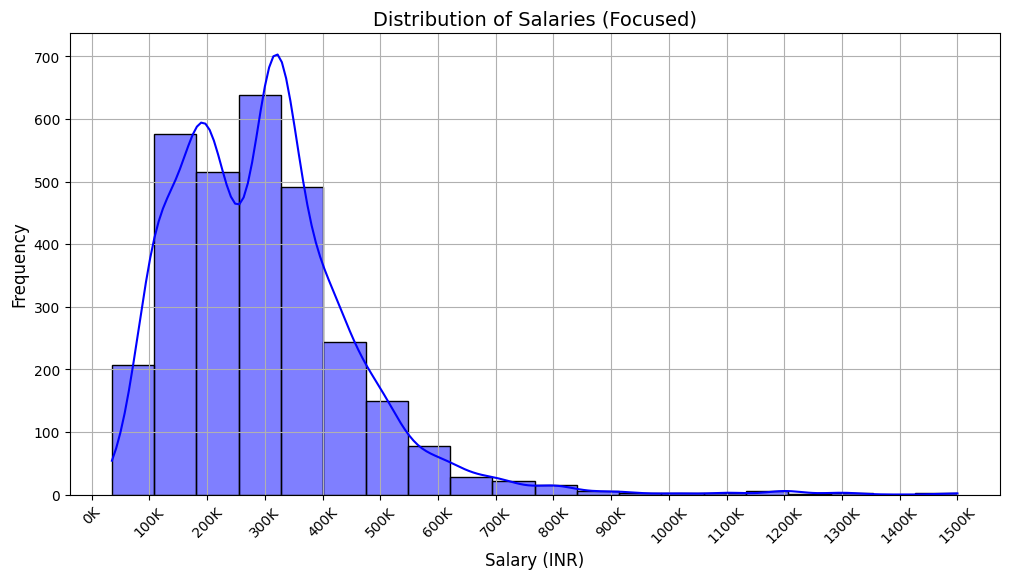

In [2]:
plt.figure(figsize=(12, 6))

# Focus on salaries within a readable range (e.g., < 1,500,000 INR)
filtered_data = data[data['Salary'] <= 1500000]

sns.histplot(filtered_data['Salary'], kde=True, bins=20, color='blue')

# Adding more meaningful X-axis labels
plt.title("Distribution of Salaries (Focused)", fontsize=14)
plt.xlabel("Salary (INR)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Set X-axis ticks in thousands or lakhs
salary_ticks = range(0, 1600000, 100000)  # Tick every 100,000 INR
salary_labels = [f"{tick//1000}K" for tick in salary_ticks]  # Convert to 'K' notation
plt.xticks(salary_ticks, salary_labels, rotation=45)  # Rotate for clarity

plt.grid(True)
plt.show()


## Why is it Chosen as a Key Visualization?
- Focus on Target Variable: <br>
As the primary objective of the regression problem is to predict salary, understanding its nature is the foundation of the analysis.<br>
- Model Impact:<br>
The distribution of the target variable directly impacts how the regression model behaves and performs.<br>
- Data Quality:<br>
Identifies anomalies, trends, and data issues (like missing values or extreme values). <br>
This visualization lays the groundwork for all further steps in the regression pipeline by providing crucial insights into the target variable. 

# Visualization 2: Salary vs College Tier
### Why is this Feature Significant?
- Direct Correlation with Salary:><br>
College Tier reflects the quality and reputation of the institution, which often translates into better job opportunities and higher salaries for graduates.
- Strong Predictor for Regression:<br>
If there is a significant difference in salaries between tiers, this feature becomes a crucial predictor for explaining variance in the target variable (Salary).
- Equity Insights:<br>
Understanding how college tier impacts salaries can highlight systemic inequalities in education and employment outcomes.

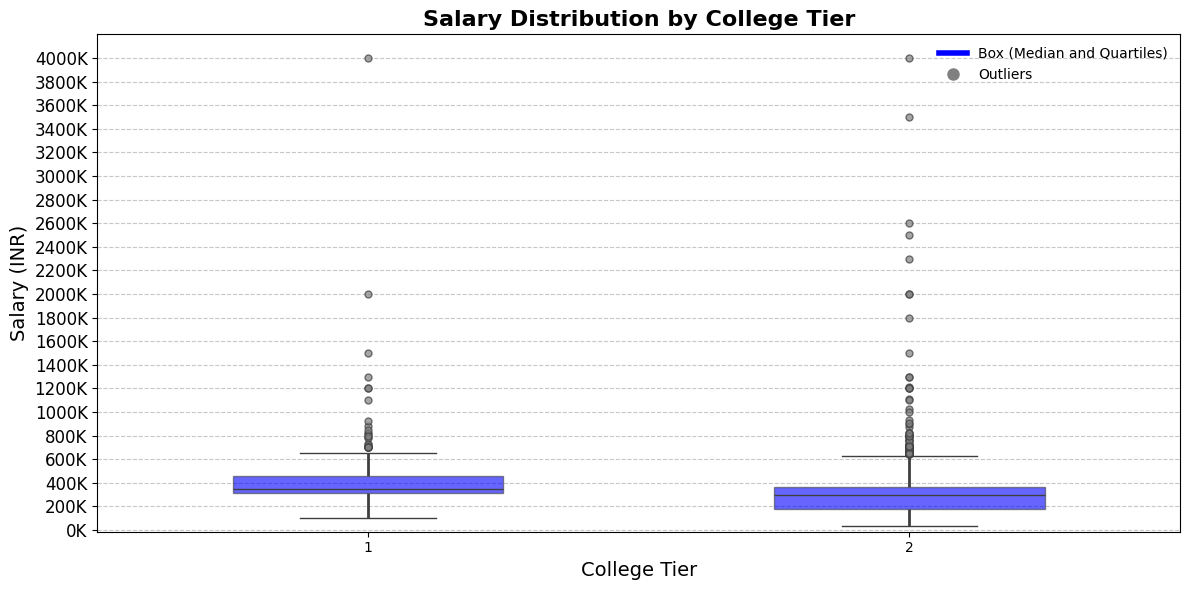

In [3]:
# Calculate the minimum and maximum values for Salary
min_salary = data['Salary'].min()
max_salary = data['Salary'].max()

# Increase the Y-axis range dynamically based on the min and max values
plt.figure(figsize=(12, 6))

# Create boxplot for Salary distribution by College Tier
sns.boxplot(
    x='CollegeTier', 
    y='Salary', 
    data=data, 
    width=0.5, 
    showcaps=True, 
    whiskerprops={'linewidth': 2}, 
    boxprops={'facecolor': 'blue', 'alpha': 0.6},  # Box with semi-transparent blue
    flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'gray', 'alpha': 0.7}  # Custom outlier design
)

# Add title and axis labels
plt.title("Salary Distribution by College Tier", fontsize=16, fontweight='bold')  # Title of the chart
plt.xlabel("College Tier", fontsize=14)  # Label for X-axis
plt.ylabel("Salary (INR)", fontsize=14)  # Label for Y-axis

# Adjust Y-axis limits dynamically based on the data
plt.ylim(min_salary - 50000, max_salary + 200000)  # Add margins to ensure all points are visible

# Customize Y-axis tick marks
plt.yticks(
    ticks=range(0, int(max_salary) + 200000, 200000),  # Add ticks at intervals of 200K INR
    labels=[f"{i//1000}K" for i in range(0, int(max_salary) + 200000, 200000)],  # Format ticks in thousands
    fontsize=12
)

# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Dashed gridlines for clarity

# Add legend with smaller size and better positioning
plt.legend(
    handles=[
        plt.Line2D([0], [0], color='blue', lw=4, label='Box (Median and Quartiles)'),  # Box element
        plt.Line2D([0], [0], color='gray', marker='o', markersize=8, label='Outliers', linestyle='')  # Outlier dots
    ],
    loc='upper right',  # Position legend in the top-right corner
    fontsize=10,  # Reduce font size for the legend
    frameon=False  # Remove legend border for a cleaner look
)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



## Why is it Chosen as a Key Visualization?
- Clear Comparison:<br>
A box plot effectively displays the differences in salary distributions between Tier 1 and Tier 2 colleges, showing medians, ranges, and outliers in a compact format.
- Focus on Categorical Impact:<br>
This visualization focuses on a categorical feature (College Tier) that likely substantially influences salaries, unlike numerical predictors that may show more granular trends.
- Insights Beyond Averages:<br>
The box plot reveals variability, interquartile ranges, and outliers, providing more depth than simple metrics like mean or median salary comparisons.

# Visualization 3: Salary vs Specialization
### Why is this Feature Significant?
- Key Driver of Career Path and Earnings: <br>
Specialization determines the type of roles and industries graduates qualify for, directly impacting earning potential. Fields like computer science and electronics often lead to high-paying technology roles, whereas fields like civil engineering may align with industries offering lower average salaries.
- Indicator of Market Demand and Skills Alignment:<br>
Salaries across specializations reflect market dynamics—higher salaries often indicate fields with greater demand or skill shortages. This makes specialization a valuable feature for predicting salary and identifying trends in the job market.

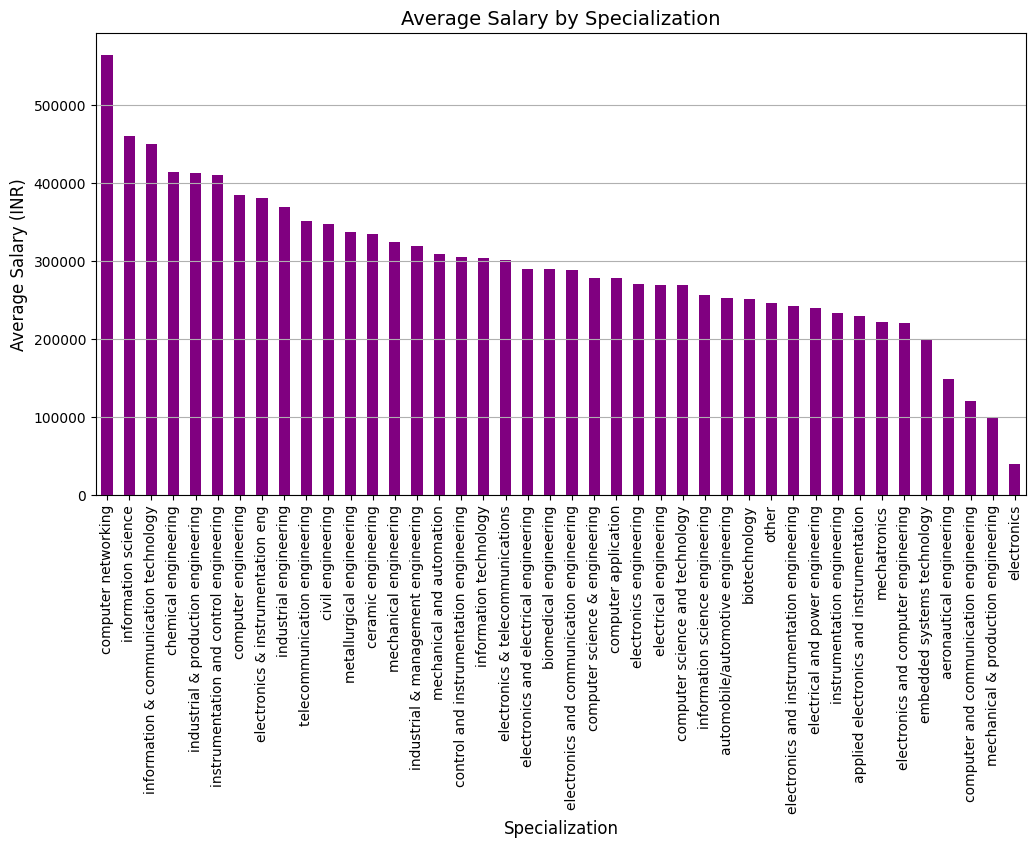

In [4]:
plt.figure(figsize=(12, 6))
avg_salary_by_spec = data.groupby('Specialization')['Salary'].mean().sort_values(ascending=False)
avg_salary_by_spec.plot(kind='bar', color='purple')
plt.title("Average Salary by Specialization", fontsize=14)
plt.xlabel("Specialization", fontsize=12)
plt.ylabel("Average Salary (INR)", fontsize=12)
plt.grid(axis='y')
plt.show()

## Why is it Chosen as a Key Visualization?
- Clear and Intuitive Comparison of Categories:<br>
A visualization like a bar plot or boxplot is ideal for categorical features such as specialization because it provides an intuitive and easily interpretable way to compare average or median salaries across multiple categories. It effectively highlights the disparities in earning potential among different specializations, making it straightforward to identify high-paying and low-paying fields. This clarity is critical for understanding how specialization contributes to salary variability, which is central to the regression problem.

- Captures the Full Scope of Salary Variance Across Specializations:<br>
This visualization reveals both the central tendencies (e.g., median or mean salaries) and the variability (e.g., range or spread) for each specialization. It ensures that the relationship between specialization and salary is captured in depth, showcasing the impact of both popular and niche fields. This level of detail helps validate specialization as a key predictive feature, ensuring the model reflects real-world salary trends tied to different career paths.

# Visualization 4: Salary vs CGPA
### Why is this Feature Significant?
- Strong Predictor of Early Career Opportunities:<br>
CGPA is often used as a benchmark by employers to evaluate a candidate’s academic competence and consistency. Higher CGPA scores can open doors to prestigious roles and companies, directly influencing salary levels for fresh graduates.

- Reflects Academic and Technical Proficiency:<br>
A high CGPA may indicate not only strong academic performance but also technical knowledge and the ability to handle complex concepts. This alignment with employer expectations makes CGPA a critical factor in predicting salary outcomes.

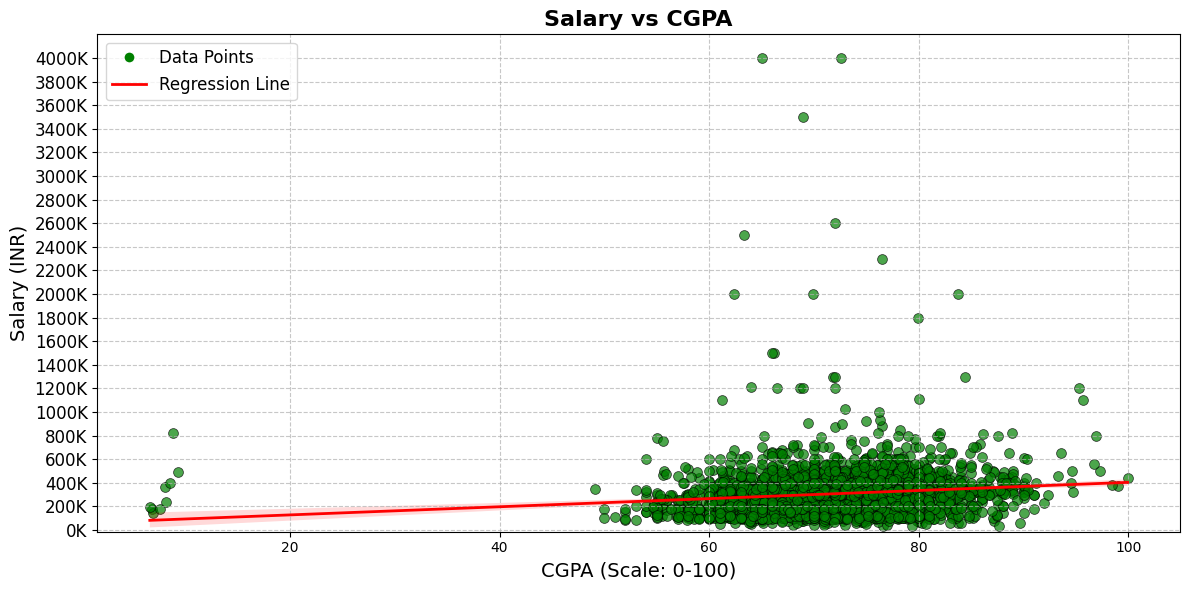

In [5]:
# Calculate the minimum and maximum values for CGPA and Salary
min_cgpa = data['collegeGPA'].min()
max_cgpa = data['collegeGPA'].max()
min_salary = data['Salary'].min()
max_salary = data['Salary'].max()

# Increase the range of X and Y axes based on the min and max values
plt.figure(figsize=(12, 6))

# Create scatter plot for CGPA vs. Salary
scatter = sns.scatterplot(
    x='collegeGPA', 
    y='Salary', 
    data=data, 
    color='green',  # Data points are green
    alpha=0.7, 
    edgecolor='black', 
    s=50  # Size of the points
)

# Add regression line
regression_line = sns.regplot(
    x='collegeGPA', 
    y='Salary', 
    data=data, 
    scatter=False,  # No extra scatter points from regplot
    color='red',  # Regression line is red
    line_kws={"linewidth": 2}  # Line width for visibility
)

# Add title and axis labels
plt.title("Salary vs CGPA", fontsize=16, fontweight='bold')  # Chart title
plt.xlabel("CGPA (Scale: 0-100)", fontsize=14)  # X-axis label
plt.ylabel("Salary (INR)", fontsize=14)  # Y-axis label

# Adjust the limits for X and Y axes
plt.xlim(min_cgpa - 5, max_cgpa + 5)  # Add margin around CGPA values
plt.ylim(min_salary - 50000, max_salary + 200000)  # Add margin around Salary values

# Customize Y-axis tick marks
plt.yticks(
    ticks=range(0, int(max_salary) + 200000, 200000),  # Add ticks at every 200K interval
    labels=[f"{i//1000}K" for i in range(0, int(max_salary) + 200000, 200000)],  # Display values in thousands (e.g., 200K)
    fontsize=12
)

# Add gridlines for better readability
plt.grid(axis='both', linestyle='--', alpha=0.7)  # Dashed gridlines with slight transparency

# Add legend to map scatter points and regression line
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Data Points'), 
        plt.Line2D([0], [0], color='red', linewidth=2, label='Regression Line')
    ],
    loc='upper left',  # Position legend in the upper-left corner
    fontsize=12  # Font size for the legend
)

# Adjust the layout to avoid overlapping elements
plt.tight_layout()

# Display the plot
plt.show()


## Why is it Chosen as a Key Visualization?
- Captures the Relationship Between Academic Achievement and Salary:<br>
A scatter plot with a trend line visually demonstrates how salaries vary with CGPA. It helps identify whether there is a positive correlation, a threshold effect, or diminishing returns, providing crucial insights for regression modeling.

- Identifies Patterns, Outliers, and Thresholds:<br>
This visualization highlights whether candidates with low CGPA consistently earn less and whether there is a point beyond which higher CGPA no longer translates into significantly higher salaries. It also identifies outliers, guiding the refinement of features in the model.

# Visualization 5: Salary vs Skill
### Why is this Feature Significant?
- Indicates Problem-Solving and Practical Aptitude:<br>
Skills like quantitative ability demonstrate critical thinking, problem-solving, and numerical reasoning. These are essential for many high-paying technical roles, such as engineering, analytics, and programming, where logical and mathematical skills are directly tied to job performance and salary potential.

- Acts as a Distinguishing Factor in Competitive Job Markets:<br>
In highly competitive industries, where many candidates may have similar academic achievements (e.g., CGPA), skill scores like Quant provide a practical benchmark for employers. These scores help identify candidates with the ability to excel in real-world tasks, making them a critical determinant of salary and job success.



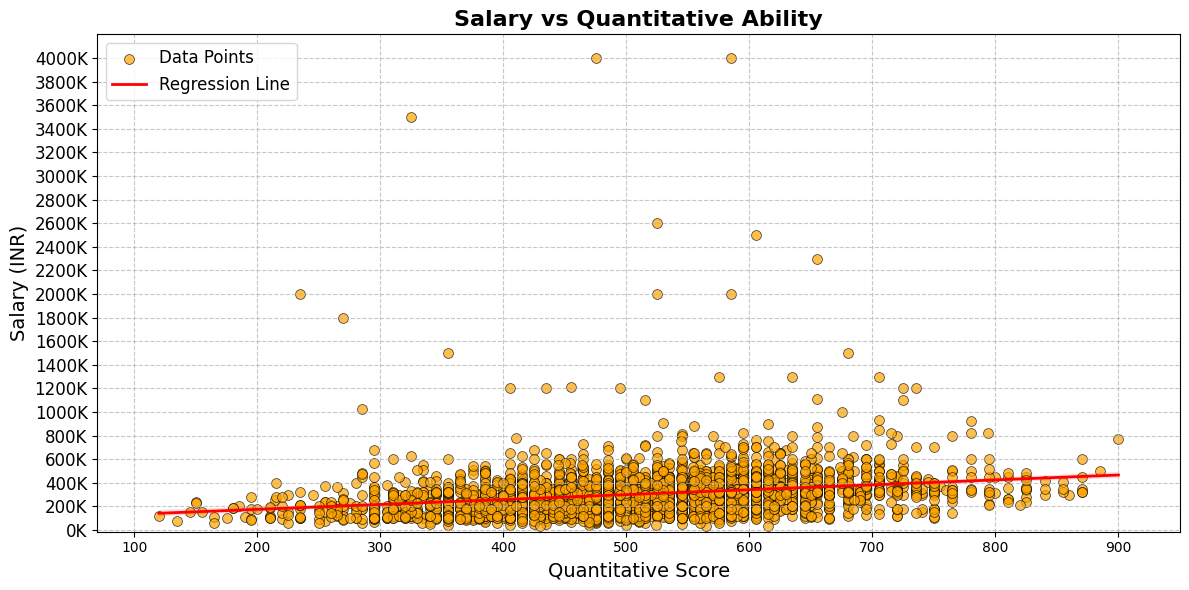

In [6]:
# Calculate the minimum and maximum values for Quant and Salary
min_quant = data['Quant'].min()
max_quant = data['Quant'].max()
min_salary = data['Salary'].min()
max_salary = data['Salary'].max()

# Increase the range of X and Y axes based on the min and max values
plt.figure(figsize=(12, 6))

# Create scatter plot for Quantitative Score vs. Salary
sns.scatterplot(
    x='Quant', 
    y='Salary', 
    data=data, 
    color='orange', 
    alpha=0.7, 
    edgecolor='black', 
    s=50  # Size of the data points
)

# Add regression line
sns.regplot(
    x='Quant', 
    y='Salary', 
    data=data, 
    scatter=False, 
    color='red', 
    line_kws={"linewidth": 2}  # Thickness of the regression line
)

# Add title and axis labels
plt.title("Salary vs Quantitative Ability", fontsize=16, fontweight='bold')  # Chart title
plt.xlabel("Quantitative Score", fontsize=14)  # X-axis label
plt.ylabel("Salary (INR)", fontsize=14)  # Y-axis label

# Adjust the limits for X and Y axes
plt.xlim(min_quant - 50, max_quant + 50)  # Add margin around Quantitative Score values
plt.ylim(min_salary - 50000, max_salary + 200000)  # Add margin around Salary values

# Customize Y-axis tick marks
plt.yticks(
    ticks=range(0, int(max_salary) + 200000, 200000),  # Add ticks at every 200K interval
    labels=[f"{i//1000}K" for i in range(0, int(max_salary) + 200000, 200000)],  # Display values in thousands (e.g., 200K)
    fontsize=12
)

# Add gridlines for better readability
plt.grid(axis='both', linestyle='--', alpha=0.7)  # Dashed gridlines with slight transparency

# Add legend with correct mapping of elements
plt.legend(
    ["Data Points", "Regression Line"],  # Correct legend labels
    loc='upper left',  # Position legend in the upper-left corner
    fontsize=12  # Font size for the legend
)

# Adjust the layout to avoid overlapping elements
plt.tight_layout()

# Display the plot
plt.show()


## Why is it Chosen as a Key Visualization?
- Reveals the Direct Impact of Quantitative Ability on Salary:<br>
Visualizing Salary vs. Quantitative Score allows us to examine the linear or nonlinear relationship between problem-solving skills and earnings. This visualization provides concrete evidence of whether higher quantitative scores correspond to higher salaries, making it essential for understanding the predictive power of this feature in the regression model.

- Highlights Variability and Patterns Specific to Quantitative Skills:<br>
A scatter plot with a regression line is the most suitable visualization for this numerical feature, as it captures both the overall trend and individual variations in the data. It helps us identify patterns like thresholds (e.g., whether salaries plateau beyond a certain score) or outliers (e.g., candidates with low scores but high salaries), enabling us to refine the regression model for better accuracy.

# Basic Model Pipeline 


In [7]:
# Handle missing values
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

non_numeric_columns = data.select_dtypes(exclude=['number']).columns
for col in non_numeric_columns:
    if not data[col].isnull().all():
        data[col] = data[col].fillna(data[col].mode()[0])

# Remove outliers in Salary
data = data[(np.abs(zscore(data['Salary'])) < 3)]

# Feature selection and target variable
X = data.drop(columns=['Salary'])
y = data['Salary']

# Apply log transformation to normalize Salary
y = np.log1p(y)  # Transform target variable

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Normalize numeric features
scaler = StandardScaler()
numeric_cols_in_X = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_cols_in_X] = scaler.fit_transform(X[numeric_cols_in_X])

# Feature selection (optional)
selector = SelectKBest(score_func=f_regression, k=20)  # Adjust 'k' as needed
X = selector.fit_transform(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)

# Reverse the log transformation for evaluation
y_test_exp = np.expm1(y_test)  # Reverse transformation for true values
y_pred_exp = np.expm1(y_pred)  # Reverse transformation for predicted values

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_exp, y_pred_exp)
mse = mean_squared_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp, y_pred_exp)

# Evaluate the model


Improved Model Performance:
Mean Absolute Error (MAE): 95103.81
Mean Squared Error (MSE): 15501787554.69
Root Mean Squared Error (RMSE): 124506.17
R² Score: 0.21
Max Error: 486273.91


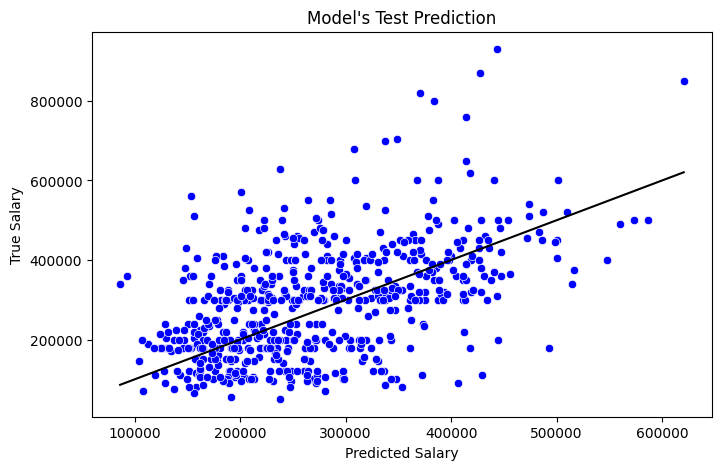

In [8]:
# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Reverse the log transformation for evaluation
y_test_exp = np.expm1(y_test)  # Reverse transformation for true values
y_pred_exp = np.expm1(y_pred)  # Reverse transformation for predicted values

# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_exp, y_pred_exp)
mse = mean_squared_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_exp, y_pred_exp)

# Display results
print("\nImproved Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Residuals
residuals = y_test_exp - y_pred_exp
max_error = residuals.abs().max()
print(f"Max Error: {max_error:.2f}")

# Plot true vs. predicted values
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=y_pred_exp, y=y_test_exp, ax=ax, color='blue')
sns.lineplot(x=y_pred_exp, y=y_pred_exp, ax=ax, color='black')
plt.title("Model's Test Prediction")
plt.xlabel("Predicted Salary")
plt.ylabel("True Salary")
plt.show()
